In [ ]:
#pip install matplotlib

In [21]:
#Import packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
from scipy.fftpack import fft, ifft,rfft

In [22]:


#Read the necessary files

insulin_data = pd.read_csv("Project 3 Files/InsulinData.csv",low_memory = False)
cgm_data = pd.read_csv("Project 3 Files/CGMData.csv",low_memory = False)


#Create a column for timestamp

insulin_data['TimeStamp'] = pd.to_datetime(insulin_data[["Date", "Time"]].apply(" ".join, axis=1))
cgm_data['TimeStamp'] = pd.to_datetime(cgm_data[["Date", "Time"]].apply(" ".join, axis=1))


#Sort by Timestamp

insulin_data = insulin_data.sort_values(by =['TimeStamp'],ascending=True)
cgm_data = cgm_data.sort_values(by =['TimeStamp'],ascending=True)



In [23]:


#Extract Meal Data Function
def extract_meal_data(ins_data,cgm_data):
    ins_data_copy = ins_data.loc[ins_data['BWZ Carb Input (grams)']>0]
    validTimeStamp = []
    minutes = 0
    time_diff = 0
    meal_data_1 = []
    #Get valid TimeStamps from Insulin Data
    for i in range(1,len(ins_data_copy)-1):
        time_diff = ins_data_copy.iloc[i+1]['TimeStamp']-ins_data_copy.iloc[i]['TimeStamp']       
        minutes = (time_diff.total_seconds())/60
        if minutes >= 120:
            validTimeStamp.append(ins_data_copy.iloc[i]['TimeStamp'])
            meal_data_1.append(ins_data_copy.iloc[i])
    meal_data_gt = pd.DataFrame(meal_data_1)
    
    #Get rows from CGM Data
    list_meal = []
    e_list=[]
    s_list=[]
    for j in validTimeStamp: 
        start = pd.to_datetime(j - timedelta(minutes=30))
        end = pd.to_datetime(j + timedelta(minutes=120))
        date = j.date().strftime('%-m/%-d/%Y')
        list_meal.append(cgm_data.loc[cgm_data['Date']== date].set_index('TimeStamp').between_time(start_time = start.strftime('%-H:%-M:%S'),end_time = end.strftime('%-H:%-M:%S'))['Sensor Glucose (mg/dL)'].values.tolist())
    list_meal = pd.DataFrame(list_meal)
    return meal_data_gt,list_meal,validTimeStamp

In [24]:
#Extract Meal Data
gt_rows,meal_data_1,validTimeStamp = extract_meal_data(insulin_data,cgm_data)
meal_data_1 = meal_data_1.iloc[:,0:24]

In [25]:
meal_data_1

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,314.0,310.0,309.0,311.0,311.0,311.0,312.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,58.0,59.0,63.0,71.0,81.0,102.0,131.0,140.0,147.0,153.0,...,151.0,155.0,163.0,164.0,NaN,166.0,168.0,164.0,169.0,178.0
2,304.0,292.0,281.0,268.0,259.0,255.0,248.0,241.0,231.0,220.0,...,224.0,228.0,233.0,243.0,256.0,262.0,270.0,277.0,274.0,269.0
3,40.0,40.0,40.0,40.0,60.0,71.0,83.0,87.0,100.0,112.0,...,123.0,112.0,89.0,77.0,69.0,66.0,67.0,71.0,75.0,74.0
4,212.0,210.0,204.0,200.0,199.0,201.0,201.0,194.0,188.0,183.0,...,169.0,172.0,179.0,192.0,203.0,205.0,210.0,213.0,212.0,216.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,57.0,58.0,62.0,74.0,104.0,110.0,126.0,133.0,135.0,141.0,...,147.0,136.0,135.0,136.0,142.0,168.0,168.0,174.0,207.0,209.0
599,209.0,219.0,221.0,221.0,216.0,217.0,215.0,211.0,201.0,200.0,...,220.0,207.0,205.0,194.0,186.0,177.0,180.0,184.0,180.0,190.0
600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142.0,145.0
601,106.0,107.0,100.0,104.0,123.0,132.0,129.0,127.0,120.0,132.0,...,178.0,182.0,180.0,168.0,166.0,167.0,169.0,176.0,173.0,166.0


In [26]:
#Cleaning the meal Data - 501 rows
index1 = meal_data_1.isna().sum(axis=1).where(lambda x:x>2).dropna().index 
meal_data_final_1 = meal_data_1.drop(meal_data_1.index[index1])

In [27]:
meal_data_final_1

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
1,58.0,59.0,63.0,71.0,81.0,102.0,131.0,140.0,147.0,153.0,...,151.0,155.0,163.0,164.0,NaN,166.0,168.0,164.0,169.0,178.0
2,304.0,292.0,281.0,268.0,259.0,255.0,248.0,241.0,231.0,220.0,...,224.0,228.0,233.0,243.0,256.0,262.0,270.0,277.0,274.0,269.0
3,40.0,40.0,40.0,40.0,60.0,71.0,83.0,87.0,100.0,112.0,...,123.0,112.0,89.0,77.0,69.0,66.0,67.0,71.0,75.0,74.0
4,212.0,210.0,204.0,200.0,199.0,201.0,201.0,194.0,188.0,183.0,...,169.0,172.0,179.0,192.0,203.0,205.0,210.0,213.0,212.0,216.0
5,145.0,141.0,137.0,133.0,129.0,124.0,125.0,122.0,123.0,130.0,...,192.0,203.0,212.0,211.0,213.0,204.0,200.0,196.0,189.0,183.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,61.0,59.0,59.0,60.0,65.0,70.0,82.0,100.0,126.0,133.0,...,108.0,106.0,110.0,116.0,127.0,140.0,146.0,153.0,158.0,162.0
598,57.0,58.0,62.0,74.0,104.0,110.0,126.0,133.0,135.0,141.0,...,147.0,136.0,135.0,136.0,142.0,168.0,168.0,174.0,207.0,209.0
599,209.0,219.0,221.0,221.0,216.0,217.0,215.0,211.0,201.0,200.0,...,220.0,207.0,205.0,194.0,186.0,177.0,180.0,184.0,180.0,190.0
601,106.0,107.0,100.0,104.0,123.0,132.0,129.0,127.0,120.0,132.0,...,178.0,182.0,180.0,168.0,166.0,167.0,169.0,176.0,173.0,166.0


In [28]:
#Function for Meal data Feature Matrix creation
def create_meal_feature_matrix(meal_data):
    pow_first_max =[]
    pow_second_max =[]
    pow_third_max =[]
    ind_third_max=[]
    ind_second_max =[]
    meal_data_temp = meal_data.interpolate(method = 'linear',axis = 1)
    #indices_to_drop = meal_data_temp.isna().sum(axis=1).replace(0,np.nan).dropna().index 
    #cleaned_data = meal_data_temp.drop(meal_data.index[indices_to_drop])
    #index2 = meal_data_temp.loc[meal_data_temp]
    cleaned_data_meal = meal_data_temp.dropna()
    index2 = cleaned_data_meal.index
    cleaned_data_meal = cleaned_data_meal.reset_index()
    for i in range(len(cleaned_data_meal)):
        arr = abs(rfft(cleaned_data_meal.iloc[:,0:30].iloc[i].values.tolist())).tolist()
        arr_copy = arr.copy()
        arr_copy.sort()
        pow_first_max.append(arr_copy[-2])
        pow_second_max.append(arr_copy[-3])
        pow_third_max.append(arr_copy[-4])
        ind_second_max.append(arr.index(arr_copy[-3]))
        ind_third_max.append(arr.index(arr_copy[-4]))
    meal_feat_matrix = pd.DataFrame()
    meal_feat_matrix['tau_time']=(cleaned_data_meal.iloc[:,22:25].idxmin(axis=1)-cleaned_data_meal.iloc[:,5:19].idxmax(axis=1))*5
    meal_feat_matrix['CGM_diff_normalized']=(cleaned_data_meal.iloc[:,5:19].max(axis=1)-cleaned_data_meal.iloc[:,22:25].min(axis=1))/(cleaned_data_meal.iloc[:,22:25].min(axis=1))
    meal_feat_matrix['pow_second_max']=pow_second_max
    meal_feat_matrix['ind_second_max']=ind_second_max
    meal_feat_matrix['pow_third_max']=pow_third_max
    meal_feat_matrix['ind_third_max']=ind_third_max
    time = cleaned_data_meal.iloc[:,22:25].idxmin(axis = 1)
    maximum = cleaned_data_meal.iloc[:,5:19].idxmax(axis = 1)
    temp_list = []
    sec_diff_data = []
    std_dev = []
    for i in range(len(cleaned_data_meal)):
        temp_list.append(np.diff(cleaned_data_meal.iloc[:,maximum[i]:time[i]].iloc[i].tolist()).max())
        sec_diff_data.append(np.diff(np.diff(cleaned_data_meal.iloc[:,maximum[i]:time[i]].iloc[i].tolist())).max())
        std_dev.append(np.std(cleaned_data_meal.iloc[i]))
    meal_feat_matrix['sec_differential']=sec_diff_data
    meal_feat_matrix['std_deviation']=std_dev
    #meal_feat_matrix['label']=1
    return meal_feat_matrix,index2

In [29]:
#Get feature matrices and dropped indexes for gt_rows from the feature matrices
meal_feat_matrix,index2 = create_meal_feature_matrix(meal_data_final_1)
meal_feat_matrix

,tau_time,CGM_diff_normalized,pow_second_max,ind_second_max,pow_third_max,ind_third_max,sec_differential,std_deviation
0,20,0.000000,416.268724,1,366.389119,4,0.0,46.670522
1,95,-0.037175,293.836881,19,292.116402,5,13.0,54.309837
2,40,0.859155,116.518282,6,89.348698,2,11.0,32.735937
3,85,-0.051887,222.186841,11,215.500000,19,6.0,40.195642
4,35,0.158470,182.553753,3,175.708204,9,5.0,45.076362
...,...,...,...,...,...,...,...,...
494,60,-0.130719,505.871323,9,488.885735,21,6.0,100.707052
495,40,-0.149425,511.062306,9,498.105211,5,20.0,99.034168
496,40,0.222222,420.497987,13,410.590170,19,12.0,79.024047
497,40,0.096386,479.209167,17,477.399187,19,10.0,92.883152


In [30]:
#print(list(index2))

In [ ]:
#Update Ground Truth DataFrame by dropping values which is dropped in Meal Data extraction.
#gt_rows = gt_rows.drop(gt_rows.index[list(index1)])
#gt_rows

In [31]:
#Update Ground Truth DataFrame by dropping values which is dropped in feature matrix and other dropna()
#index_temp = gt_rows.iloc[:,:].index.where(lambda x:x in list(index2)).index
#gt_rows = gt_rows.loc[gt_rows[list(index2)]]
gt_rows = gt_rows.iloc[list(index2)]

In [32]:
#Binning  carb values
min_carb = gt_rows['BWZ Carb Input (grams)'].min()
max_carb = gt_rows['BWZ Carb Input (grams)'].max()
number_of_bins = round((max_carb-min_carb) / 20) # 20 is given

bin_list = []

#As min and max carb is given,we calculate for that much bins.
for i in gt_rows['BWZ Carb Input (grams)']:
    if (i >= min_carb) & (i < min_carb+20) :
        bin_list.append(0)
    if (i >= min_carb+20) & (i < min_carb+40) :
        bin_list.append(1)
    if (i >= min_carb+40) & (i < min_carb+60) :
        bin_list.append(2)
    if (i >= min_carb+60) & (i < min_carb+80) :
        bin_list.append(3)
    if (i >= min_carb+80) & (i < min_carb+100) :
        bin_list.append(4)
    if (i >= min_carb+103) & (i <= max_carb) :
        bin_list.append(5)
bin_df = pd.DataFrame(bin_list)
bin_df
#min_carb,max_carb,number_of_bins

,0
0,5
1,3
2,2
3,1
4,2
...,...
494,1
495,0
496,1
497,3


In [33]:
#Implementing K-Means
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(meal_feat_matrix)
kmeans = KMeans(n_clusters=number_of_bins,max_iter=100)
kmeans.fit(scaled_features)
#kmeans.n_iter_,kmeans.cluster_centers_,kmeans.inertia_
kmeans_labels = kmeans.labels_
kmeans_labels

array([1, 0, 4, 0, 3, 3, 4, 0, 3, 3, 4, 1, 3, 3, 3, 3, 4, 4, 3, 0, 3, 4,
       4, 4, 1, 1, 0, 1, 1, 3, 3, 3, 4, 1, 0, 3, 0, 3, 3, 4, 3, 4, 3, 3,
       1, 4, 4, 4, 2, 3, 0, 3, 4, 3, 4, 4, 4, 4, 3, 3, 3, 4, 3, 4, 3, 2,
       3, 3, 2, 1, 1, 4, 4, 4, 3, 3, 3, 3, 3, 4, 3, 3, 1, 3, 2, 3, 1, 4,
       3, 3, 3, 3, 4, 3, 3, 4, 4, 3, 4, 3, 1, 4, 1, 2, 2, 4, 4, 3, 3, 3,
       4, 3, 3, 2, 1, 3, 3, 4, 1, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 4, 4, 3,
       4, 3, 1, 3, 4, 1, 3, 3, 3, 4, 4, 3, 4, 3, 4, 2, 4, 3, 4, 4, 3, 4,
       4, 4, 4, 1, 2, 1, 3, 4, 3, 3, 4, 1, 4, 2, 1, 3, 1, 3, 3, 3, 4, 3,
       4, 4, 4, 3, 4, 2, 4, 1, 3, 4, 4, 4, 4, 3, 3, 3, 4, 4, 3, 1, 3, 3,
       2, 3, 1, 2, 3, 2, 4, 3, 3, 2, 4, 3, 4, 3, 1, 0, 4, 4, 3, 1, 2, 2,
       0, 1, 3, 3, 1, 4, 4, 2, 2, 2, 0, 3, 4, 3, 0, 2, 3, 3, 4, 3, 4, 3,
       3, 4, 3, 3, 4, 3, 0, 4, 3, 3, 3, 4, 3, 0, 0, 0, 2, 3, 3, 4, 3, 4,
       0, 4, 3, 4, 3, 0, 3, 3, 4, 4, 4, 3, 0, 2, 1, 3, 1, 0, 0, 3, 0, 2,
       3, 1, 4, 1, 3, 1, 0, 0, 1, 3, 4, 4, 0, 4, 0,

In [34]:
#Calculate SSE,Entropy and purity for K-means
from scipy.stats import entropy
#K_means_SSE
K_means_SSE = kmeans.inertia_

#Calculate cluster and bin matrix
n_clusters = number_of_bins
entropy_list = []
count_of_indiv_cl_list = []
Total_entropy_num =0.0
K_means_CB_matrix = np.zeros((n_clusters, number_of_bins), dtype=int)
for i in range(len(kmeans_labels)):
    K_means_CB_matrix[kmeans_labels[i],bin_df[0][i]]+=1
    
#for j in range(K_means_CB_matrix.shape[0]):
base = 2  
pk = K_means_CB_matrix
entropy_list.append(entropy(pk, base=base,axis = 1))
count_of_indiv_cl_list = K_means_CB_matrix.sum(axis = 1)
for k in range(len(entropy_list)):
    Total_entropy_num += count_of_indiv_cl_list[k]*entropy_list[0][k]
Total_entropy_den = len(kmeans_labels)
K_means_Total_entropy = Total_entropy_num/Total_entropy_den


#for i in range(K_means_CB_matrix.shape[0]):
#    entropy = 0.0
#    for j in range(K_means_CB_matrix.shape[1]):
#        count_of_indiv_cl_list.append(K_means_CB_matrix[i].sum())
#        if K_means_CB_matrix[i][j] != 0:
#            entropy += (((K_means_CB_matrix[i][j])/count_of_indiv_cl_list[i])* np.log2(K_means_CB_matrix[i][j]/count_of_indiv_cl_list[i]))
#        entropy_list.append(-entropy)  
#for k in range(len(entropy_list)):
#    Total_entropy_num += count_of_indiv_cl_list[k]*entropy_list[k]
#Total_entropy_den = len(kmeans_labels)
#Total_entropy = Total_entropy_num/Total_entropy_den
#Total_entropy

#K_means_purity
K_means__purity = K_means_CB_matrix.max(axis=1).sum()/len(kmeans_labels)
K_means_SSE,K_means_Total_entropy,K_means__purity

(1767.8145653248698, 0.21791277797104214, 0.34468937875751504)

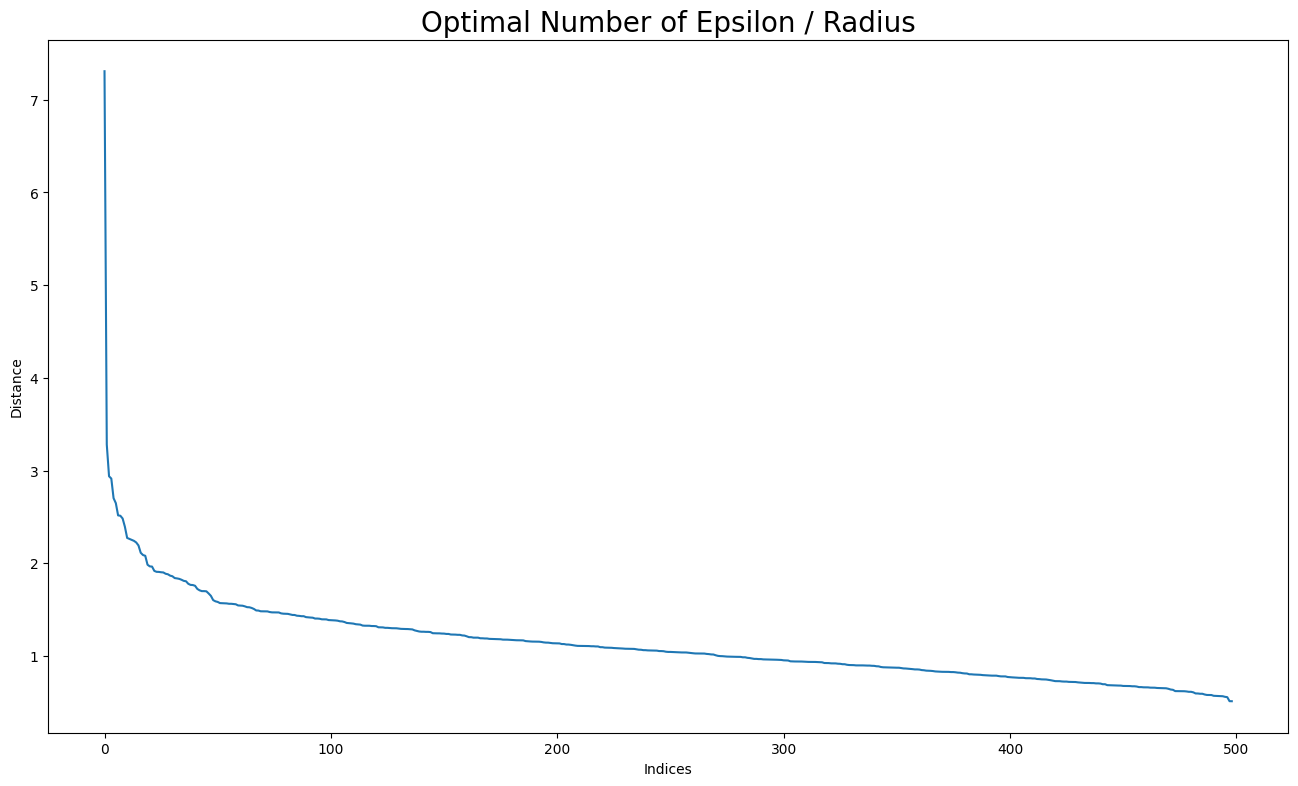

In [35]:
# Finding parameter values to pass to DBSCAN 
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.cluster import BisectingKMeans

nbrs = NearestNeighbors(n_neighbors=20).fit(scaled_features)
distances, indices = nbrs.kneighbors(scaled_features)
distanceDec = sorted(distances[:,2], reverse=True)
plt.figure(figsize = (16,9))
plt.plot(indices[:,0],distanceDec);
plt.xlabel('Indices')
plt.ylabel('Distance')
plt.title('Optimal Number of Epsilon / Radius', fontsize = 20)
plt.show()

In [42]:
#Get labels from DBSCAN algo
#From the above graph, we take optimal value for eps and then for min_samples, it is mentioned that the value should
#be >= no of dimensions so, 2*8 = 16
db_scan = DBSCAN(eps=2.5,min_samples=20).fit(scaled_features)
db_scan.fit(scaled_features)
db_scan_labels = db_scan.labels_

#We get all in one cluster and By using K-means bisecting, we get,
#Remove noisy data
noise_removed_scaled_data = pd.DataFrame(scaled_features[db_scan_labels==0])
bisect_means = BisectingKMeans(n_clusters=number_of_bins).fit(noise_removed_scaled_data)
bisect_mean_label = bisect_means.labels_
bisect_mean_label

array([5, 4, 0, 0, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0,
       1, 0, 5, 5, 4, 2, 5, 2, 2, 2, 1, 5, 0, 2, 4, 2, 2, 0, 2, 0, 2, 2,
       5, 0, 0, 0, 5, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 5, 2,
       2, 3, 5, 5, 2, 0, 1, 2, 2, 2, 2, 2, 0, 2, 2, 5, 2, 3, 2, 2, 0, 2,
       2, 2, 2, 0, 2, 2, 1, 0, 2, 0, 2, 2, 1, 5, 1, 3, 0, 0, 2, 2, 2, 0,
       2, 2, 1, 5, 2, 2, 0, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 0,
       2, 5, 2, 2, 5, 2, 2, 2, 0, 0, 2, 1, 2, 0, 1, 0, 2, 0, 0, 2, 1, 0,
       0, 0, 2, 1, 2, 2, 0, 2, 2, 0, 5, 1, 5, 2, 5, 2, 2, 2, 1, 2, 0, 1,
       2, 2, 2, 1, 0, 2, 2, 0, 0, 1, 0, 2, 2, 2, 0, 0, 2, 2, 2, 2, 1, 2,
       5, 3, 2, 3, 0, 2, 2, 1, 0, 2, 0, 2, 2, 0, 0, 0, 2, 2, 1, 3, 0, 2,
       2, 2, 5, 0, 2, 1, 1, 1, 0, 2, 1, 2, 1, 3, 2, 2, 0, 2, 0, 2, 2, 0,
       2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 4, 4, 0, 3, 2, 2, 0, 2, 0, 0, 0,
       2, 1, 2, 0, 2, 2, 1, 0, 1, 2, 0, 1, 5, 2, 2, 4, 4, 2, 0, 2, 2, 0,
       5, 2, 2, 0, 0, 2, 2, 0, 3, 4, 2, 5, 2, 3, 2,

In [39]:
#Calculations SSE,Entropy and purity for DBSCAN

#DBSCAN_SSE
DBSCAN_SSE = bisect_means.inertia_

#Calculate cluster and bin matrix
#n_clusters = number_of_bins
entropy_list = []
count_of_indiv_cl_list = []
Total_entropy_num =0.0
DBSCAN_CB_matrix = np.zeros((n_clusters, number_of_bins), dtype=int)
for i in range(len(bisect_mean_label)):
    DBSCAN_CB_matrix[bisect_mean_label[i],bin_df[0][i]]+=1
    
#for j in range(DBSCAN_CB_matrix.shape[0]):
base = 2  
pk = DBSCAN_CB_matrix
entropy_list.append(entropy(pk, base=base,axis = 1))
count_of_indiv_cl_list = DBSCAN_CB_matrix.sum(axis = 1)
for k in range(len(entropy_list)):
    Total_entropy_num += count_of_indiv_cl_list[k]*entropy_list[0][k]
Total_entropy_den = len(bisect_mean_label)
DBSCAN_Total_entropy = Total_entropy_num/Total_entropy_den
#K_means_purity
DBSCAN__purity = DBSCAN_CB_matrix.max(axis=1).sum()/len(bisect_mean_label)
DBSCAN_SSE,DBSCAN_Total_entropy,DBSCAN__purity

(600.2017158606035, 0.2745390594239872, 0.3363914373088685)

In [ ]:
#K_means_CB_matrix
#len(bisect_mean_label)

In [18]:
answerlist = np.zeros((1,6))
answerlist[0][0] = K_means_SSE
answerlist[0][1] = DBSCAN_SSE
answerlist[0][2] = K_means_Total_entropy
answerlist[0][3] = DBSCAN_Total_entropy
answerlist[0][4] = K_means__purity
answerlist[0][5] = DBSCAN__purity
answer_df = pd.DataFrame(answerlist)

In [19]:
answerlist

array([[1.77423056e+03, 1.63957788e+03, 1.57788589e-01, 3.70862482e-01,
        3.38677355e-01, 3.36734694e-01]])

In [20]:
answer_df.to_csv('Result3.csv',header=False, index=False)